In [35]:
import matplotlib.pyplot as plt
import numpy as np
#np.set_printoptions(threshold=np.nan) 
import pandas as pd
import seaborn as sns

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch, Polygon
from mpl_toolkits.basemap import Basemap

%matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

df=pd.read_csv('testdata.csv')
df.head()

g_case_no      y_lat      x_lng                             f_addr  \
0   11000001  43.091474 -87.984090    5700 W CAPITOL DR MILWAUKEE, WI   
1   11000002  43.068454 -87.918139        2736 N 6TH ST MILWAUKEE, WI   
2   11000009  43.122443 -88.014475  8223 W THURSTON AVE MILWAUKEE, WI   
3   11000014  43.056875 -87.941243         2020 N 23 ST MILWAUKEE, WI   
4   11000024  43.054717 -87.936219         1840 N 19 ST MILWAUKEE, WI   

                                         gf_addr          c_case_type  \
0    5700 W Capitol Dr, Milwaukee, WI 53216, USA   Municipal citation   
1        2736 N 6th St, Milwaukee, WI 53212, USA   Municipal citation   
2  8223 W Thurston Ave, Milwaukee, WI 53218, USA  Summons & Complaint   
3       2020 N 23rd St, Milwaukee, WI 53205, USA  Summons & Complaint   
4       1840 N 19th St, Milwaukee, WI 53205, USA  Summons & Complaint   

                                         c_violation  \
0                   Ordinance 110-35-1, Retail Theft   
1  Ordinance 105-138-2, Resisting / Obstructing P...   
2  Ordinance 200 through 295, Building Code Viola...   
3  Ordinance 200 through 295, Building Code Viola...   
4  Ordinance 200 through 295, Building Code Viola...   

             c_violation_date j_finding  
0  2011-01-03 14:40:00.000000    Guilty  
1  2011-01-03 16:00:00.000000    Guilty  
2  2010-05-07 00:00:00.000000    Guilty  
3  2010-06-08 00:00:00.000000    Guilty  
4  2010-03-30 00:00:00.000000    Guilty

In [36]:
#drops address errors outside milwaukee
df = df[(df['x_lng'] > -88.0676) & (df['x_lng'] < -87.8640)
               & (df['y_lat'] > 42.9197) & (df['y_lat'] < 43.1953)]

In [37]:
guilty=df[df.j_finding == 'Guilty']
guilty=guilty.append(df[df.j_finding == 'Guilty - Suspended Sentence'])
guilty2=guilty.drop_duplicates(['f_addr'], keep='first')
notGuilty= df[df.j_finding == 'Not Guilty']
notGuilty=notGuilty.append(df[df.j_finding == 'Dismissed with Prejudice'])
notGuilty=notGuilty.append(df[df.j_finding == 'Dismissed without Prejudice'])
notGuilty2=notGuilty.drop_duplicates(['f_addr'],keep='first')

#notGuilty.tail(20)

2958

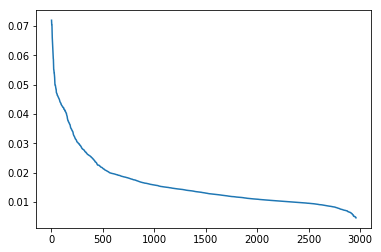

In [48]:
data=notGuilty2


#stores eps for min pts on guilty, no duplicates
params={
    5:.0025,
    20:.005,
    33:.008,
    50:.01,
    75:.012,
    100:.012,
    150:.025,
    200:.02
    
}

paramsNG={
    10:.02,
    25:.015,
    100:.02
}


n = 100

nbrs = NearestNeighbors(n_neighbors=n).fit(data[['x_lng','y_lat']])
distances, indices = nbrs.kneighbors(data[['x_lng','y_lat']])

#returns only the nearest n neighbors and their distances
distanceDec = sorted(distances[:,n-1], reverse=True)
#plt.plot(indices[:,0], distanceDec)
plt.plot(list(range(1,len(data)+1)), distanceDec)

len(data)

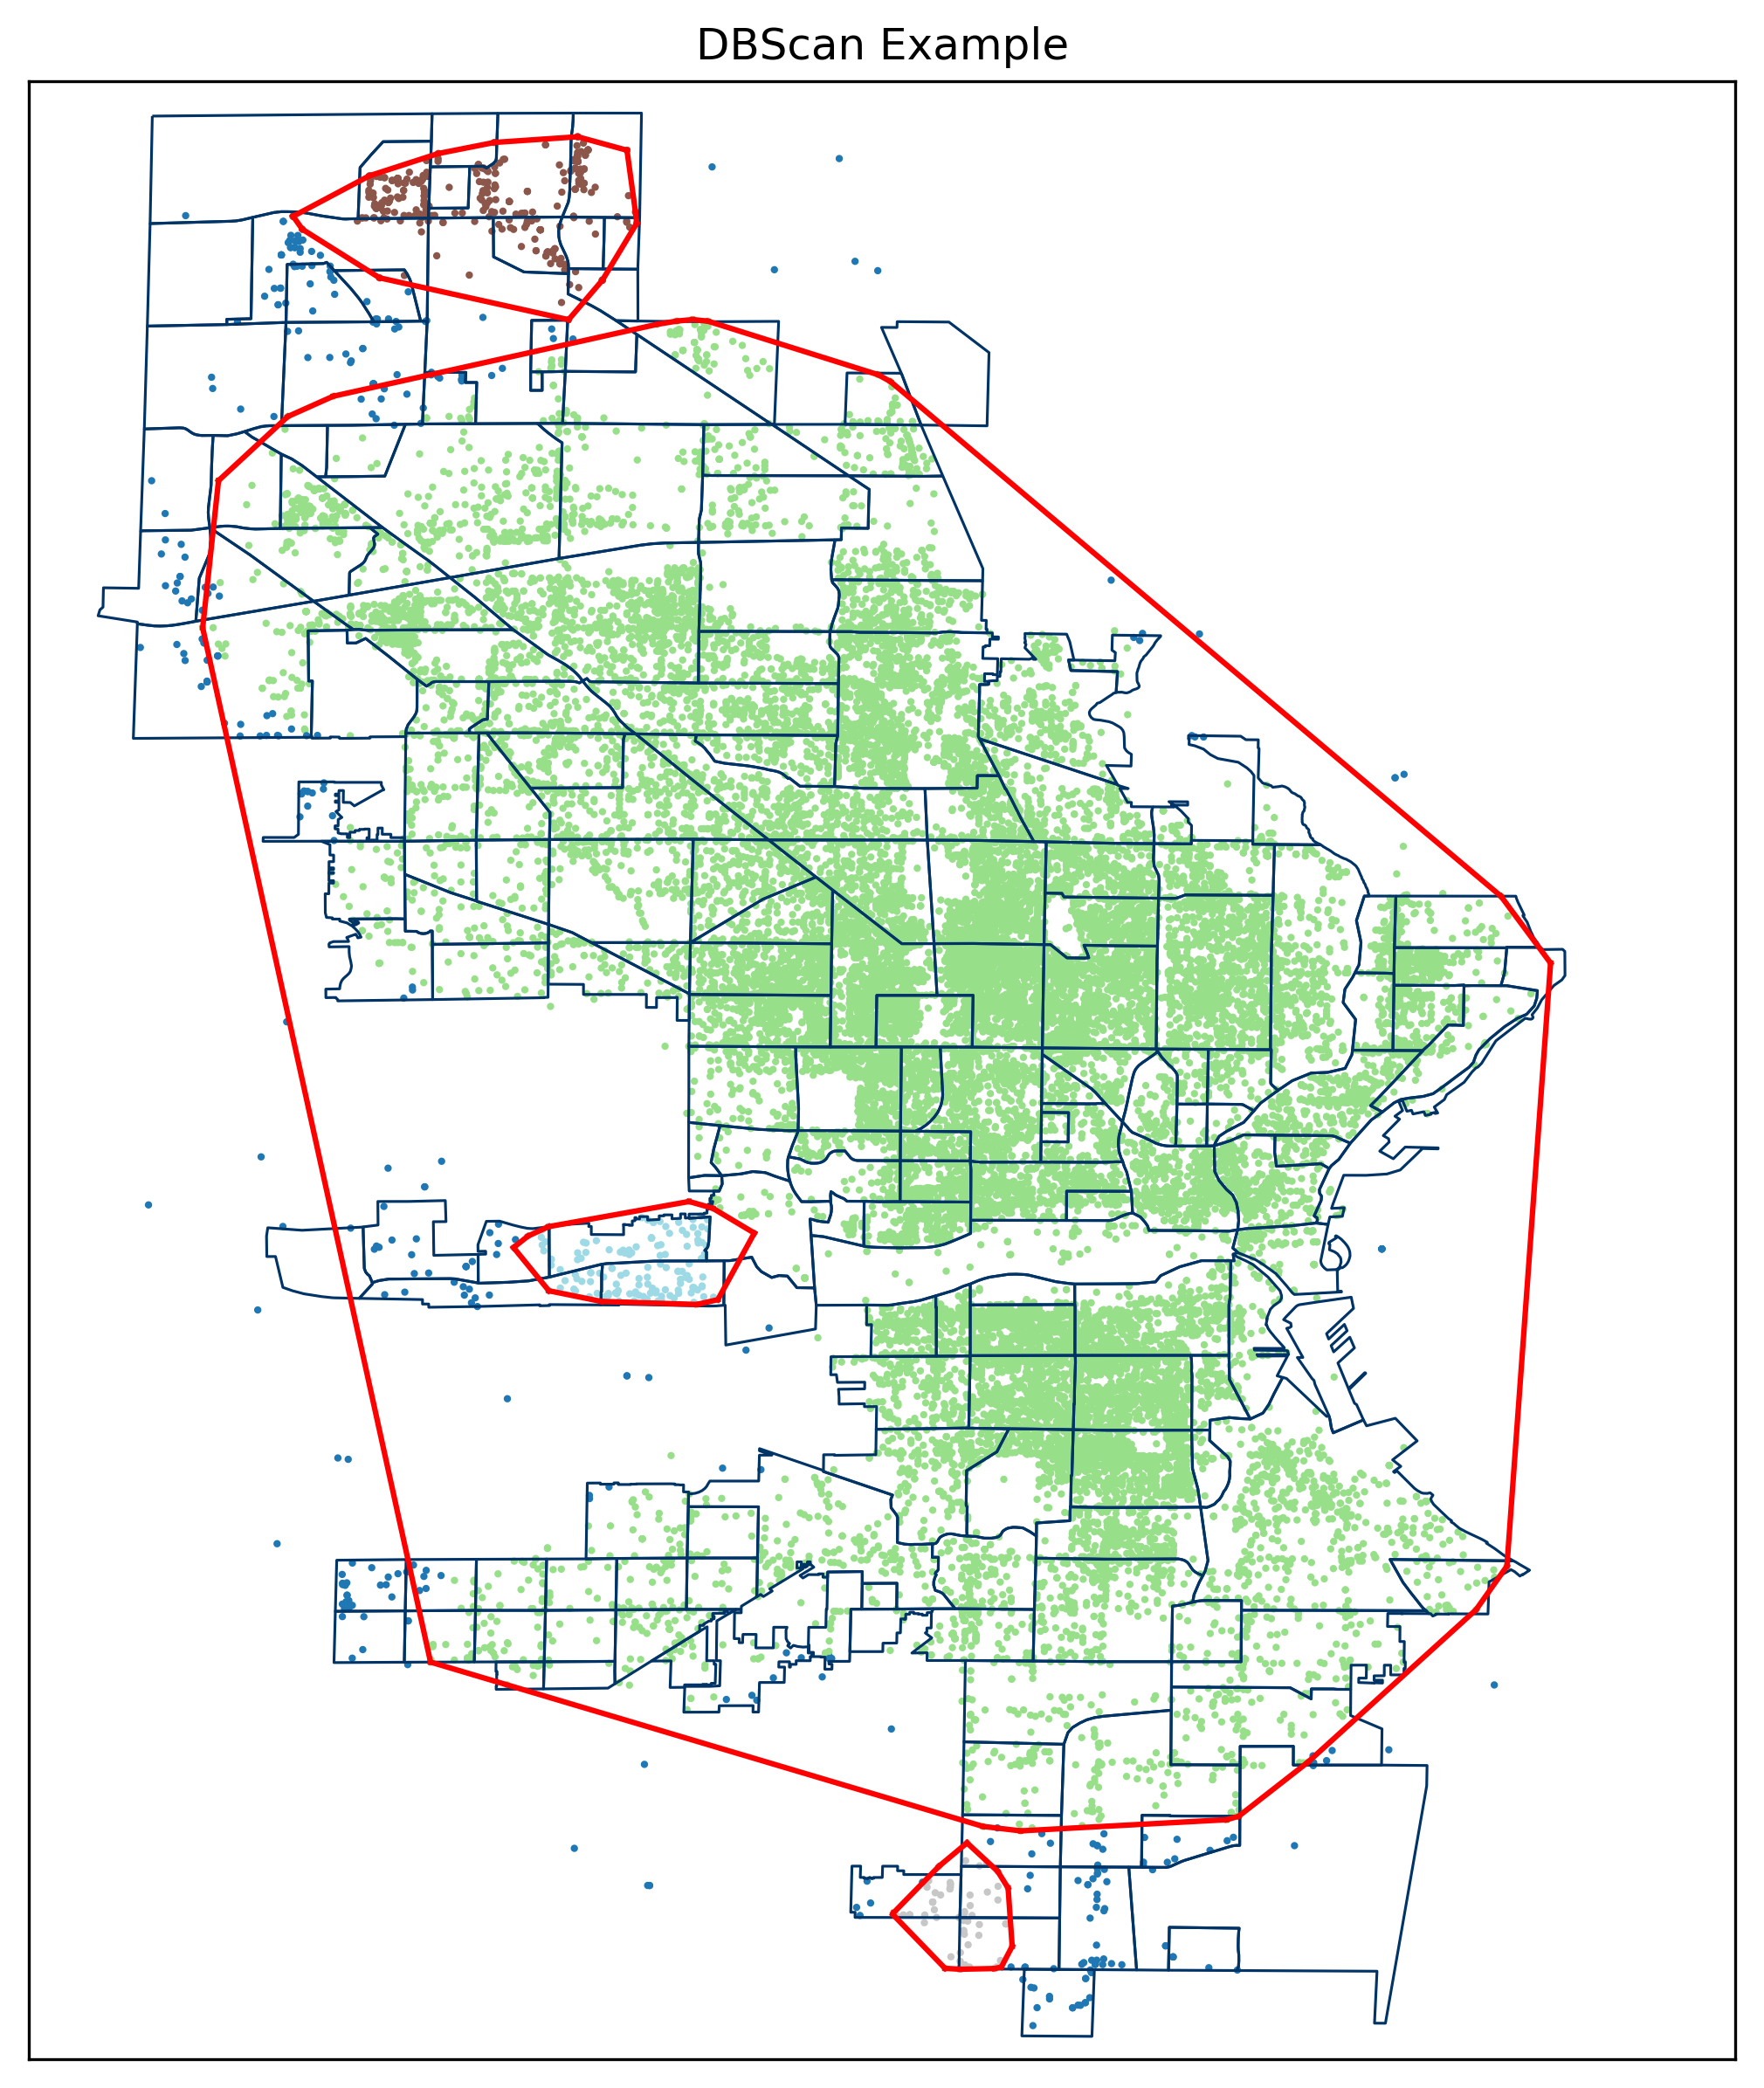

In [44]:
fig=plt.figure(figsize=(15,10), dpi=300)
Ax=fig.add_subplot(111)

map=Basemap(projection = 'cyl',
           resolution = 'h',
              lat_0 = 43.0389025,
              lon_0 = -87.9064736,
              llcrnrlon = -88.080736,
              llcrnrlat = 42.917670,
              urcrnrlon = -87.839722,
              urcrnrlat = 43.19712)
map.readshapefile('mke_nei/mke_nei', name='ald',color='#003366', linewidth=0.75)

data=guilty2
e=.01
p=50

dbscan=DBSCAN(eps=e, min_samples=p,metric='manhattan')
labels=dbscan.fit_predict(data[['x_lng','y_lat']])
data=data.assign(clusterLabel=labels)

l=max(labels)
for i in range(0,l+1):
    di=data[data.clusterLabel == i]
    hull=ConvexHull(di[['x_lng','y_lat']])
    for simplex in hull.simplices:
        plt.plot(hull.points[simplex,0], hull.points[simplex,1], 'r-')
    
    #convex_hull_plot_2d(hull, ax=Ax)
    #poly=Polygon(di[['x_lng','y_lat']], True, alpha=0.5, edgecolor='red')
    #patches.append(poly)
    #p = PatchCollection(patches, alpha=0.4)
    #ax.add_patch(poly)


plt.scatter(data['x_lng'], data['y_lat'], s=1 ,c=labels, cmap='tab20')
plt.title('DBScan, eps=' + str(e) + ', minPts=' + str(p))

plt.show()

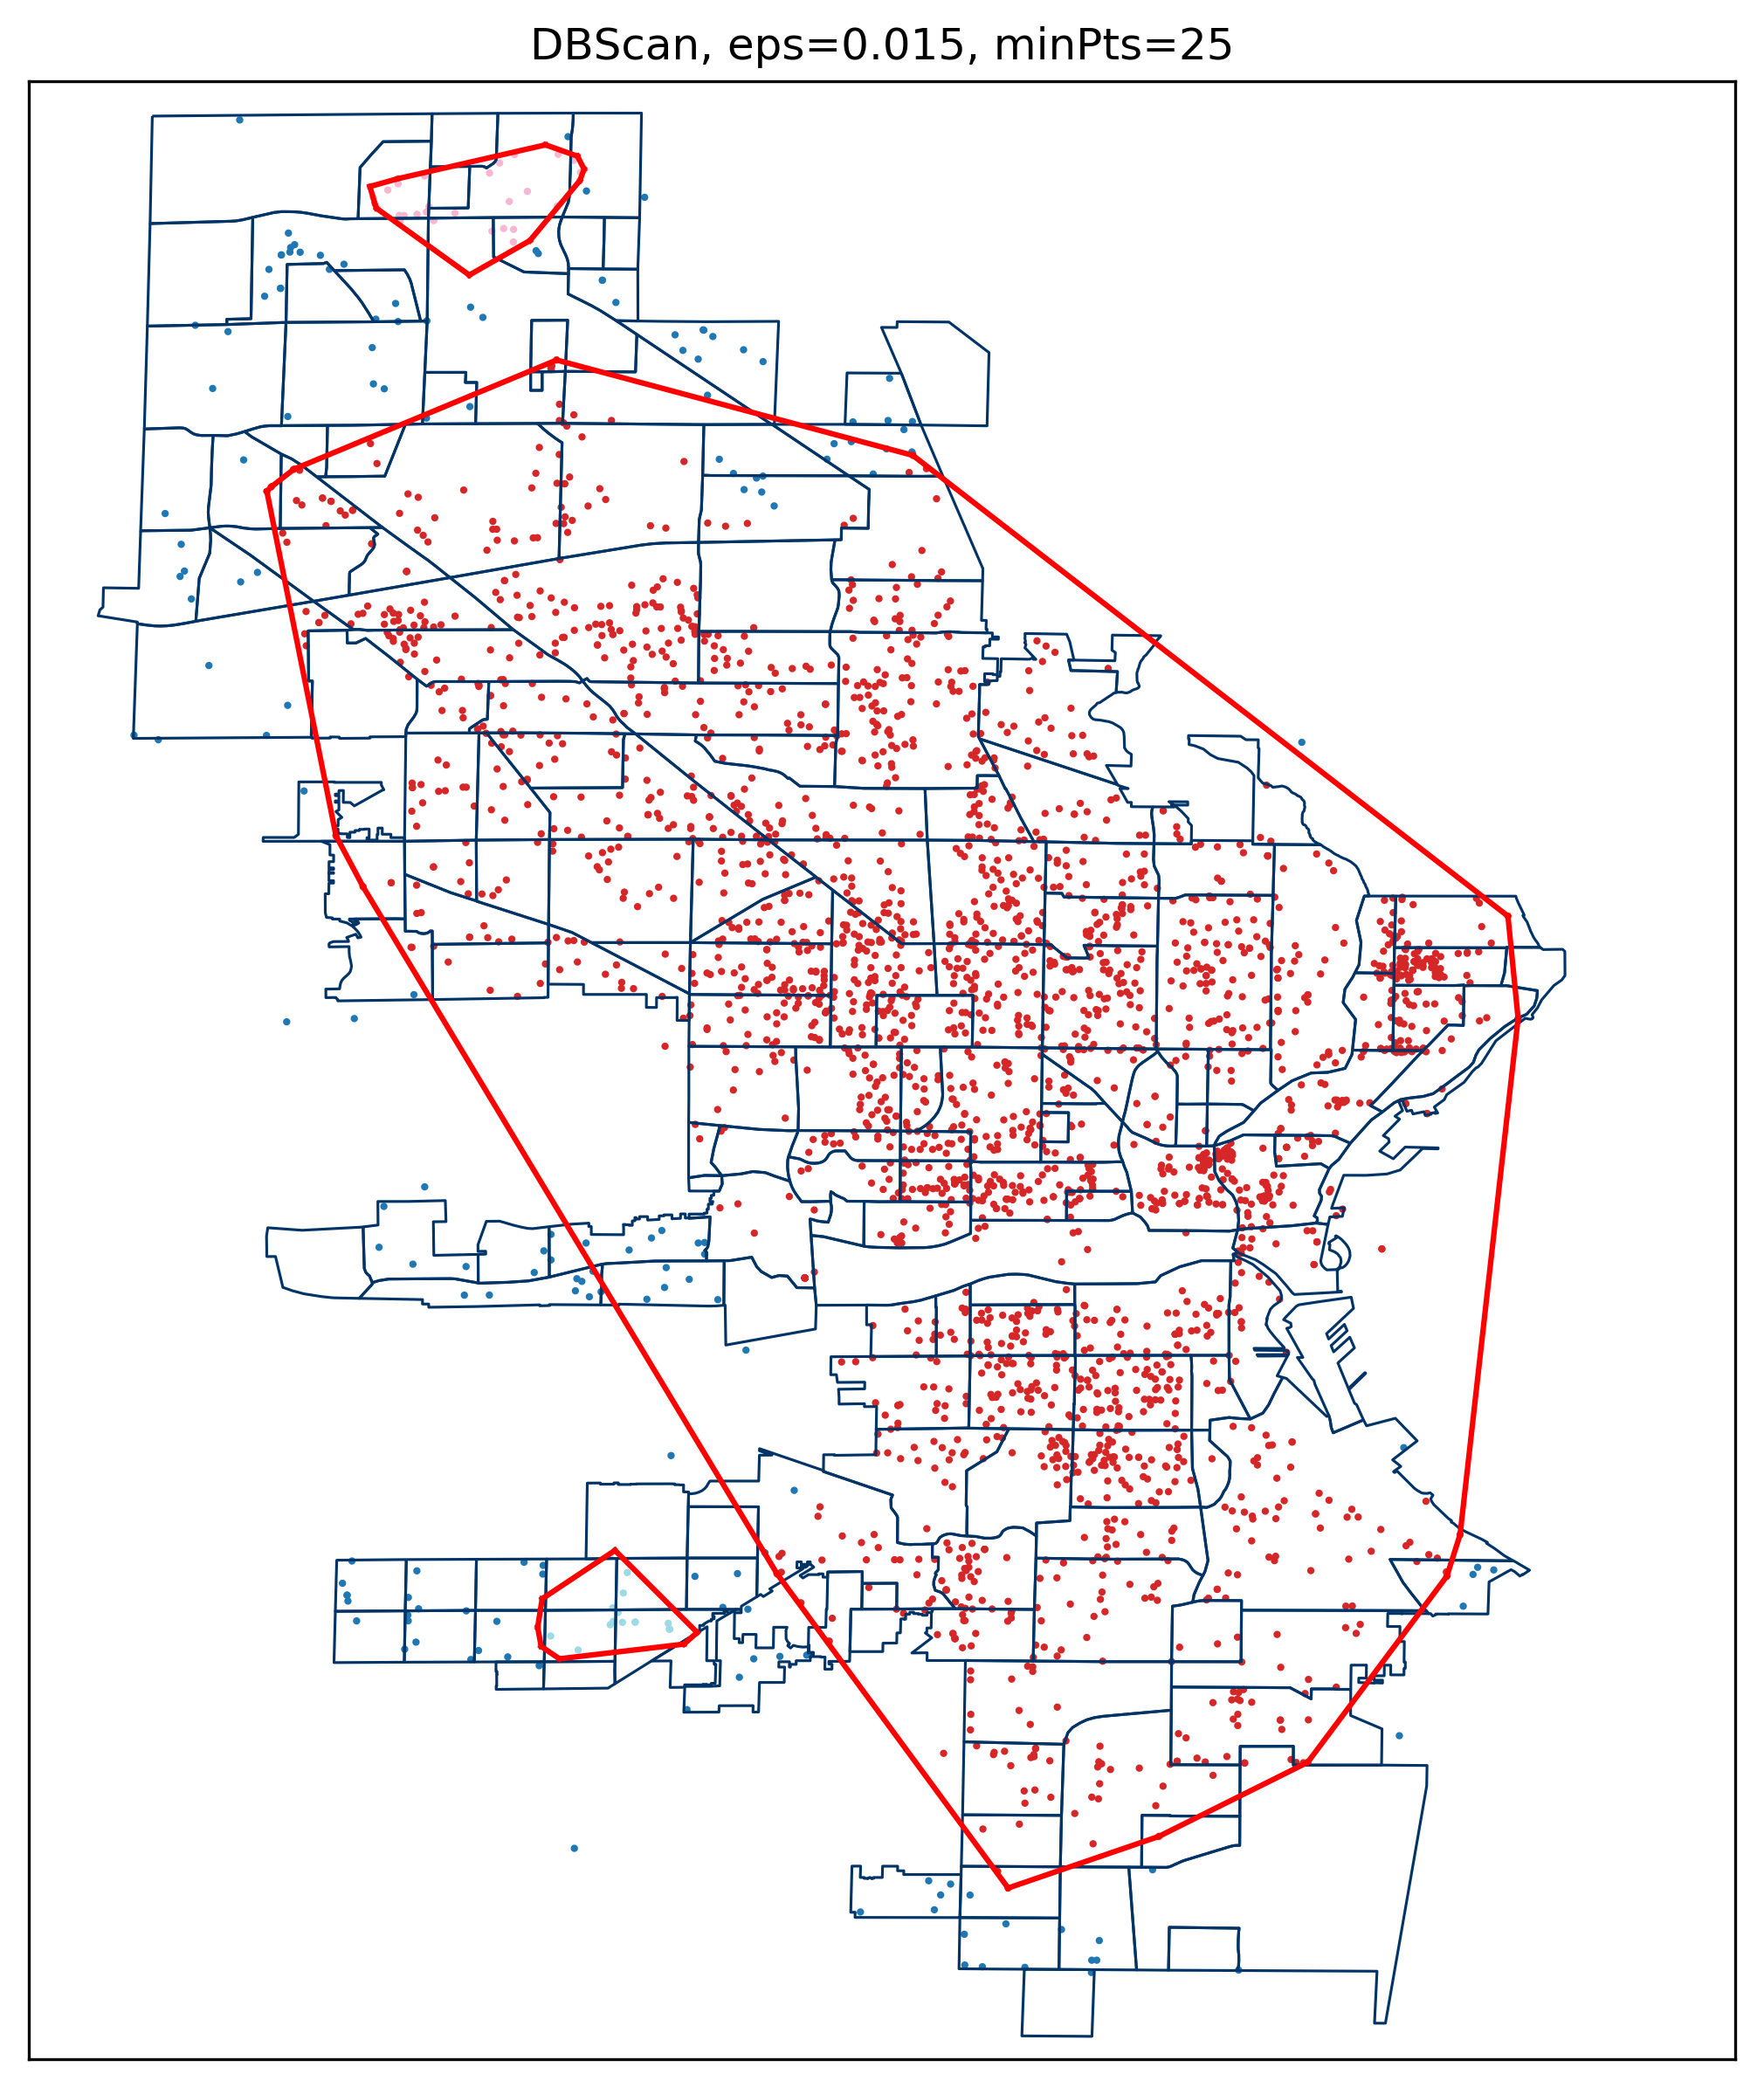

In [49]:
fig=plt.figure(figsize=(15,10), dpi=300)
Ax=fig.add_subplot(111)

map=Basemap(projection = 'cyl',
           resolution = 'h',
              lat_0 = 43.0389025,
              lon_0 = -87.9064736,
              llcrnrlon = -88.080736,
              llcrnrlat = 42.917670,
              urcrnrlon = -87.839722,
              urcrnrlat = 43.19712)
map.readshapefile('mke_nei/mke_nei', name='ald',color='#003366', linewidth=0.75)

data=notGuilty2
e=.015
p=25

dbscan=DBSCAN(eps=e, min_samples=p,metric='manhattan')
labels=dbscan.fit_predict(data[['x_lng','y_lat']])
data=data.assign(clusterLabel=labels)

l=max(labels)
for i in range(0,l+1):
    di=data[data.clusterLabel == i]
    hull=ConvexHull(di[['x_lng','y_lat']])
    for simplex in hull.simplices:
        plt.plot(hull.points[simplex,0], hull.points[simplex,1], 'r-')
    
    #convex_hull_plot_2d(hull, ax=Ax)
    #poly=Polygon(di[['x_lng','y_lat']], True, alpha=0.5, edgecolor='red')
    #patches.append(poly)
    #p = PatchCollection(patches, alpha=0.4)
    #ax.add_patch(poly)


plt.scatter(data['x_lng'], data['y_lat'], s=1 ,c=labels, cmap='tab20')
plt.title('DBScan, eps=' + str(e) + ', minPts=' + str(p))

plt.show()

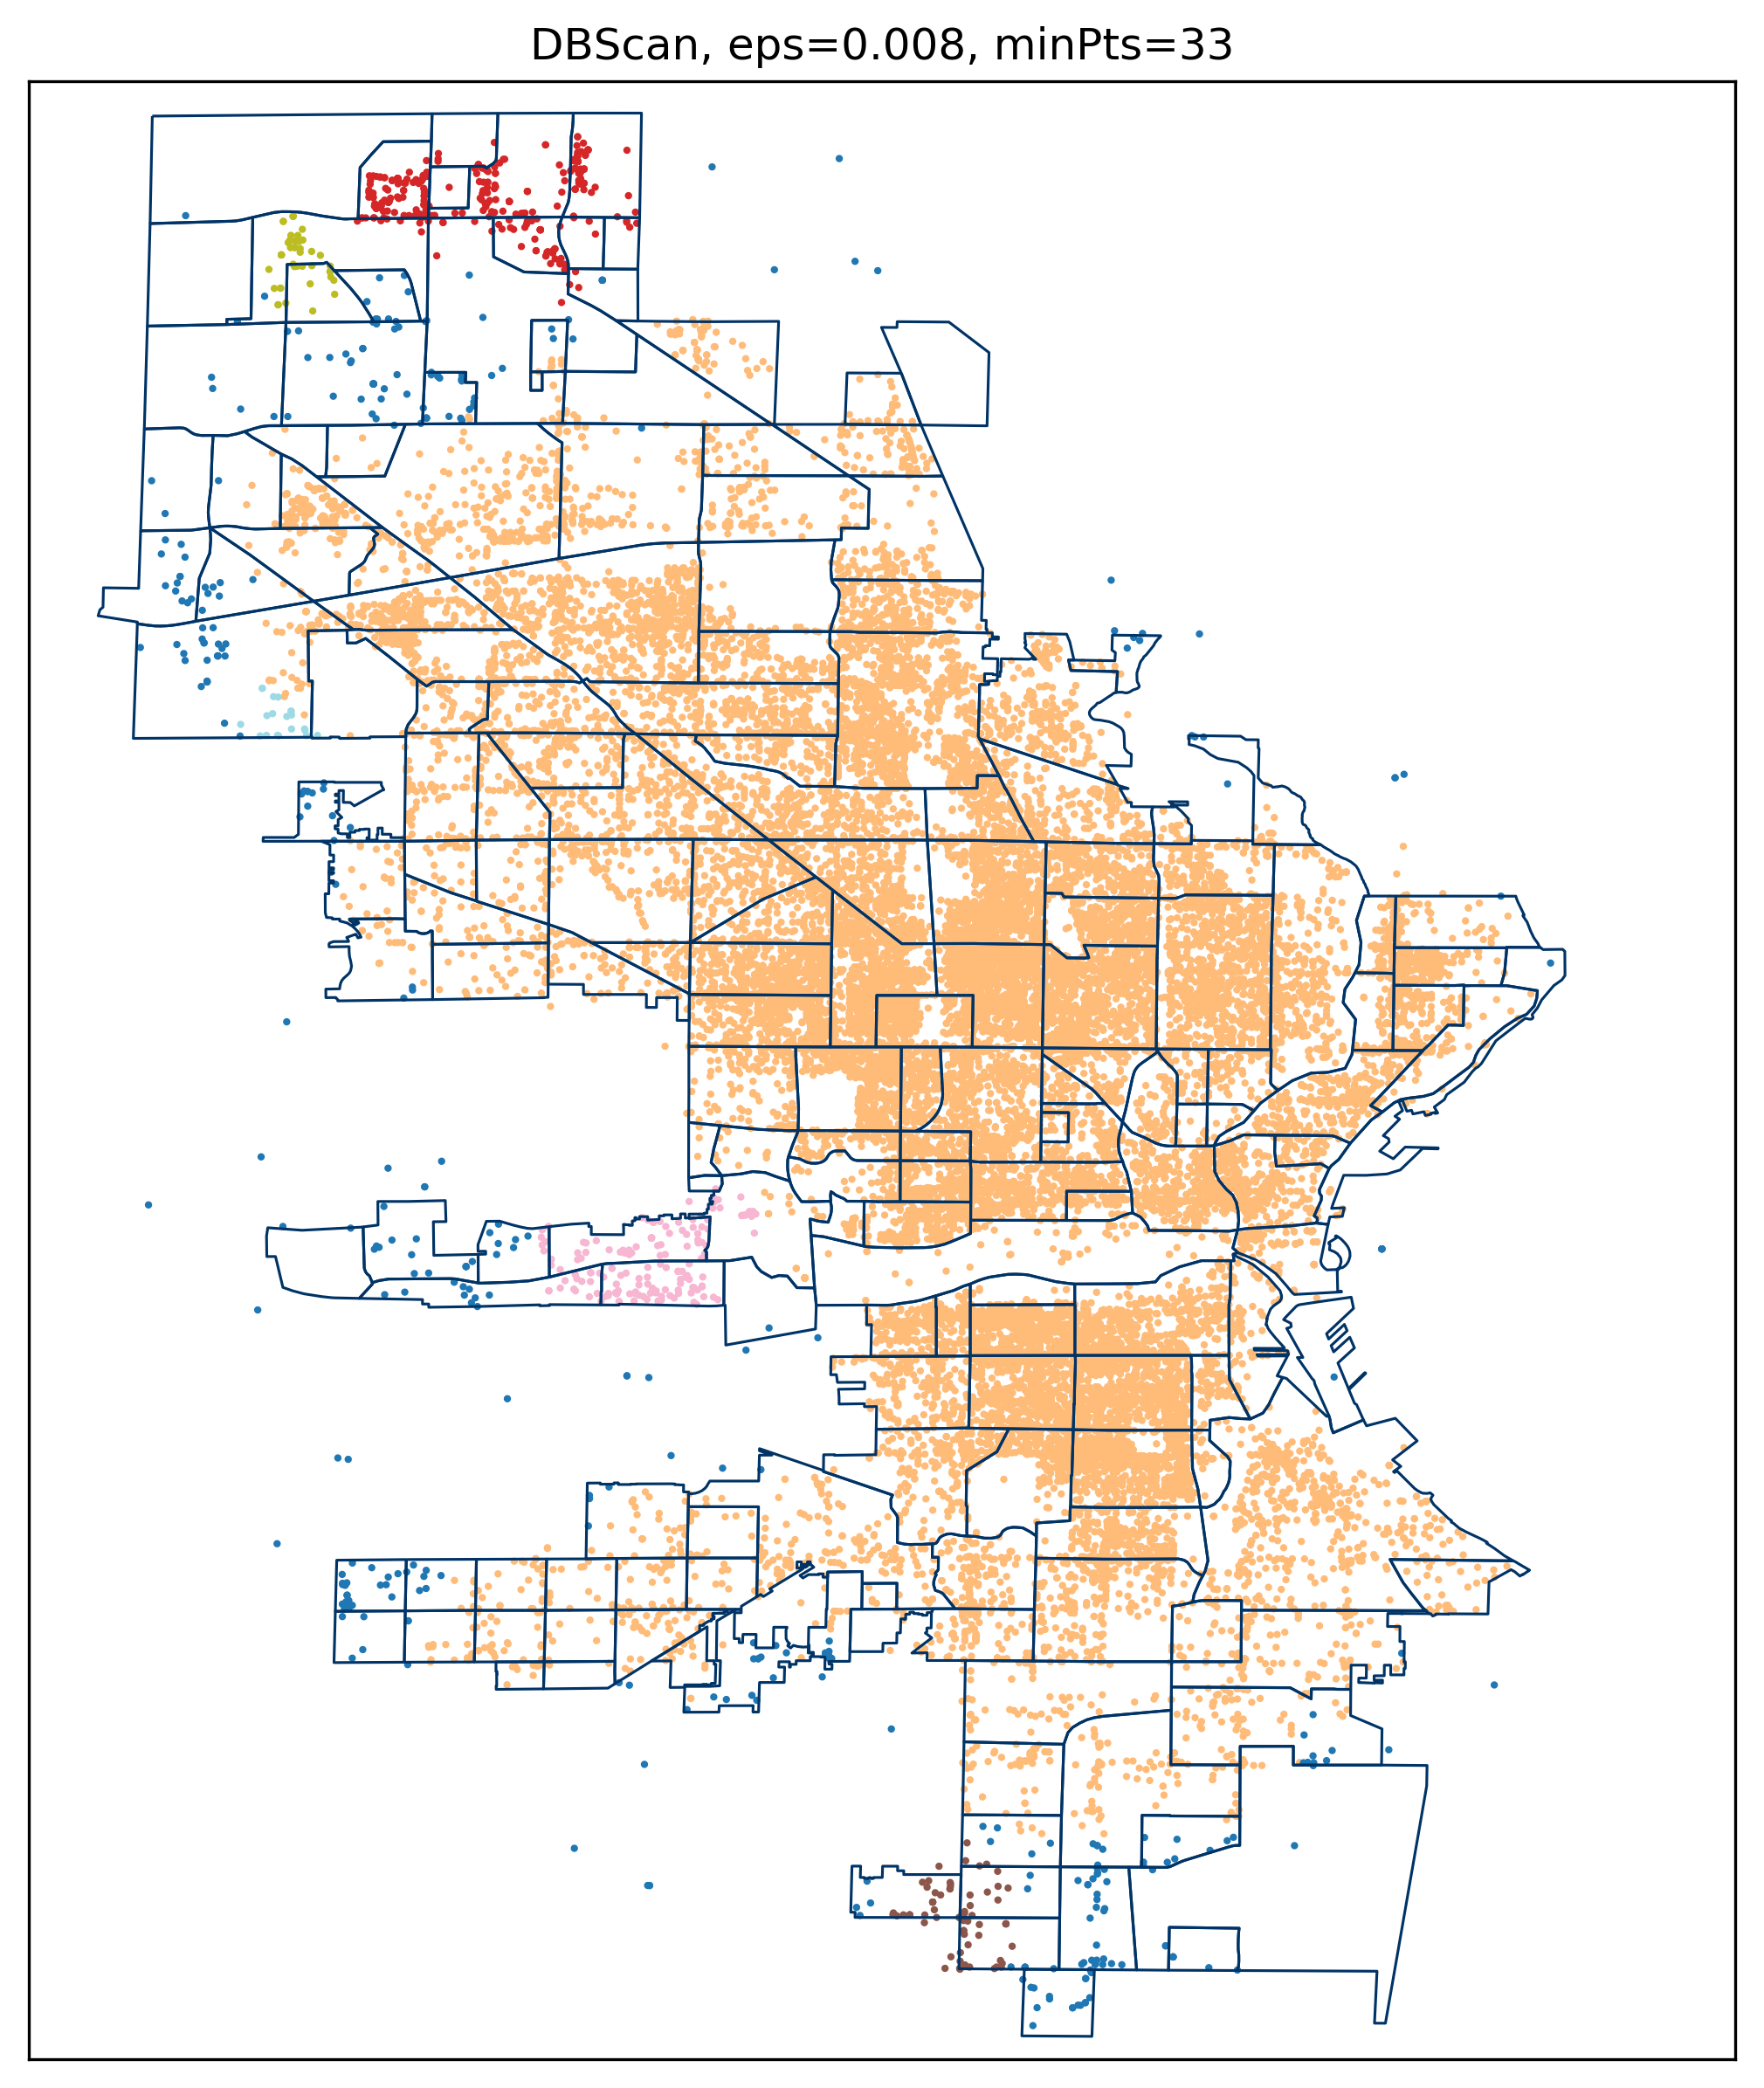

In [28]:
#buggy extra iteration


fig=plt.figure(figsize=(15,10), dpi=300)
ax=fig.add_subplot(111)

map=Basemap(projection = 'cyl',
           resolution = 'h',
              lat_0 = 43.0389025,
              lon_0 = -87.9064736,
              llcrnrlon = -88.080736,
              llcrnrlat = 42.917670,
              urcrnrlon = -87.839722,
              urcrnrlat = 43.19712)
map.readshapefile('mke_nei/mke_nei', name='ald',color='#003366', linewidth=0.75)

data=guilty2
e=.008
p=33

dbscan=DBSCAN(eps=e, min_samples=p,metric='manhattan')
labels=dbscan.fit_predict(data[['x_lng','y_lat']])
data.assign(clusterLabel=labels)

hull=ConvexHull(data[['x_lng','y_lat']])

#l=max(labels)
#for i in range(0,l+1):
    #hull=ConvexHull(data[['x_lng','y_lat']])
    #hull.vertices
    #patches = []
    #di=data[data['clusterLabel'] == i]
    #poly=Polygon(di[['x_lng','y_lat']], True, alpha=0.3, edgecolor='red')
    #patches.append(poly)
    #l=max(labels)
    #p = PatchCollection(patches, alpha=0.4)
    #ax.add_patch(poly)


plt.scatter(data['x_lng'], data['y_lat'], s=1 ,c=labels, cmap='tab20')
plt.title('DBScan, eps=' + str(e) + ', minPts=' + str(p))

plt.show()